In [1]:
import sys
import numpy as np

class Node:
    def __init__(self, val, next_node=None):
        self.val = val
        self.next_node = next_node
        
class LinkedList:
    def __init__(self, head):
        self.head = head
        
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    else:
        return v / norm

In [11]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline
%reload_ext autoreload
%autoreload 
from IPython.display import HTML, display

sys.path.insert(0, '../')
from flightgoggles.env import *

# -- CONSTANT VARS ---
num_waypoints = 5
radius = 8
start_pose = np.array([0, -15., -2., np.pi / 2])

target_pose = np.zeros(4)
target_pose[:3] = start_pose[:3] + np.array([9.0,-9.0,0.0])
target_pose[3] = start_pose[3] + np.pi/2

EPSILON = np.linalg.norm(start_pose[:3] - target_pose[:3]) / num_waypoints # how decide this??
OVERSHOOT = EPSILON
# -- END CONSTANT VARS -- 
string = "with start pose at {}, target {}, num_waypoints {}, epsilon {:.2}, & overshoot {:.2}...".format(
    start_pose, target_pose, num_waypoints, EPSILON, OVERSHOOT)

waypoint_coords = np.vstack((np.linspace(start_pose[0], target_pose[0], num=num_waypoints),
                             np.linspace(start_pose[1], target_pose[1], num=num_waypoints),
                             np.linspace(start_pose[2], target_pose[2], num=num_waypoints),
                             np.linspace(start_pose[3], target_pose[3], num=num_waypoints)))

head = Node(waypoint_coords.T[0])
waypoint_ll = LinkedList(head)
p = head
for n in waypoint_coords.T:
    curr = Node(n)
    p.next_node = curr
    p = curr

if __name__ == "__main__":
    env = flightgoggles_env(
        cfg_dir="../config",
        cfg_fgclient="FlightGogglesClient_testing.yaml",
        cfg_uav="multicopterDynamicsSimSpeed.yaml") # 30 max_speed/accel multicopterDynamicsSimSpeed
    env.set_state_vehicle(vehicle_id="uav1", 
                          position = waypoint_ll.head.val[:3],
                          attitude_euler_angle=np.array([0., 0., 0.]))
    curr_pos = env.get_state("uav1")["position"]
    curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
    curr_vel = env.get_state("uav1")["velocity"]

    att_accumulator = np.array([curr_att])
    pos_accumulator = np.array([curr_pos])
    
    curr_waypoint = waypoint_ll.head
    
    time_counter = 0
    crash = False
    while curr_waypoint:
        if (not curr_waypoint.next_node):
            EPSILON = 0.01
            OVERSHOOT = 0
        
        while np.linalg.norm(curr_pos - curr_waypoint.val[:3]) >= EPSILON:
            time_counter += 0.01
            curr_pos = env.get_state("uav1")["position"]
            curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
            curr_vel = env.get_state("uav1")["velocity"]
            
            curr_vel = np.append(curr_vel, 0)
            
            xy_vel = normalize(curr_vel)
            xy_vel[2] = 0
            xy_vel[3] = 0
                        
            collided = env.proceed_waypoint(vehicle_id="uav1",
                                            waypoint_command=curr_waypoint.val + xy_vel * OVERSHOOT,
                                            duration=0.01)
    
            att_accumulator = np.append(att_accumulator, curr_att)
            pos_accumulator = np.vstack((pos_accumulator, curr_pos))
            if collided:
                crash = True
                break
        if crash:
            print("CRASHED! :(")
            break
        
        curr_waypoint = curr_waypoint.next_node
    
    if not crash:
        f = open("observation notes linear.txt", "a")
        f.write(string + " it took {:.2f} sec\n".format(time_counter))
        f.close()
    
    with np.printoptions(precision=2, suppress=True):
        print("Final pose", np.append(env.get_state("uav1")["position"],
                                      env.get_state("uav1")["attitude_euler_angle"][2]))

    ani_set = env.plot_state_video(flag_save=False, filename="uav", dpi=400)
    if "cam1" in ani_set.keys():
        display(HTML(ani_set["cam1"].to_html5_video()))
    env.close()











Final pose [  9.   -23.99  -2.    -3.12]


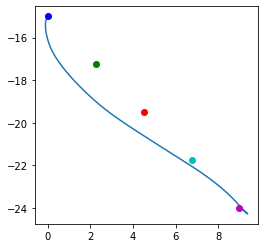

In [13]:
# Orange dots are the waypoints, dotted are waypoints
# coloration suggests the order
import itertools
import matplotlib.pyplot as plt

colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

plt.gca().set_aspect('equal', adjustable='box')
plt.plot(pos_accumulator.T[0], pos_accumulator.T[1])
for column in waypoint_coords.T:
    plt.plot(column[0], column[1], 'o' + next(colors))

In [4]:
# import matplotlib.pyplot as plt
# x = np.arange(att_accumulator.size)
# y = att_accumulator
# #linear with a gap b/c pi to -pi
# plt.plot(x, y, marker='.')